In [1]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_X_y
from py_files.features import distance, generate_features
from config import data_path
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn import linear_model
import time
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
pd.options.display.float_format = '{:.6f}'.format

In [2]:
X, y = get_X_y(force_clean=True)
# X, y = get_X_y()
X = generate_features(X, y)
X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])

/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [3]:
X.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,...,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm,distance_km,temperature_2m (°C),precipitation (mm),cloudcover (%),avg_cluster_duration
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,3,1,0,...,1,0,-0.965926,-0.258819,0.405086,2.208255,6.400000,0.200000,100.000000,814.728261
1,1,2016-03-14 17:19:42,1,-73.993095,40.747917,-74.006340,40.734406,3,1,0,...,1,0,-0.965926,-0.258819,0.405066,2.975163,6.400000,0.200000,100.000000,802.820588
2,1,2016-03-14 16:57:39,5,-73.979507,40.785347,-73.970268,40.799091,3,1,0,...,1,0,-0.866025,-0.500000,0.404982,2.555654,6.400000,0.200000,100.000000,827.276087
3,1,2016-03-14 17:01:41,1,-73.984245,40.749043,-73.999893,40.734074,3,1,0,...,1,0,-0.965926,-0.258819,0.404997,3.404428,6.400000,0.200000,100.000000,893.413174
4,1,2016-03-14 17:16:07,1,-74.006760,40.705559,-73.980568,40.787540,3,1,0,...,1,0,-0.965926,-0.258819,0.405052,12.028330,6.400000,0.200000,100.000000,687.900000


/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


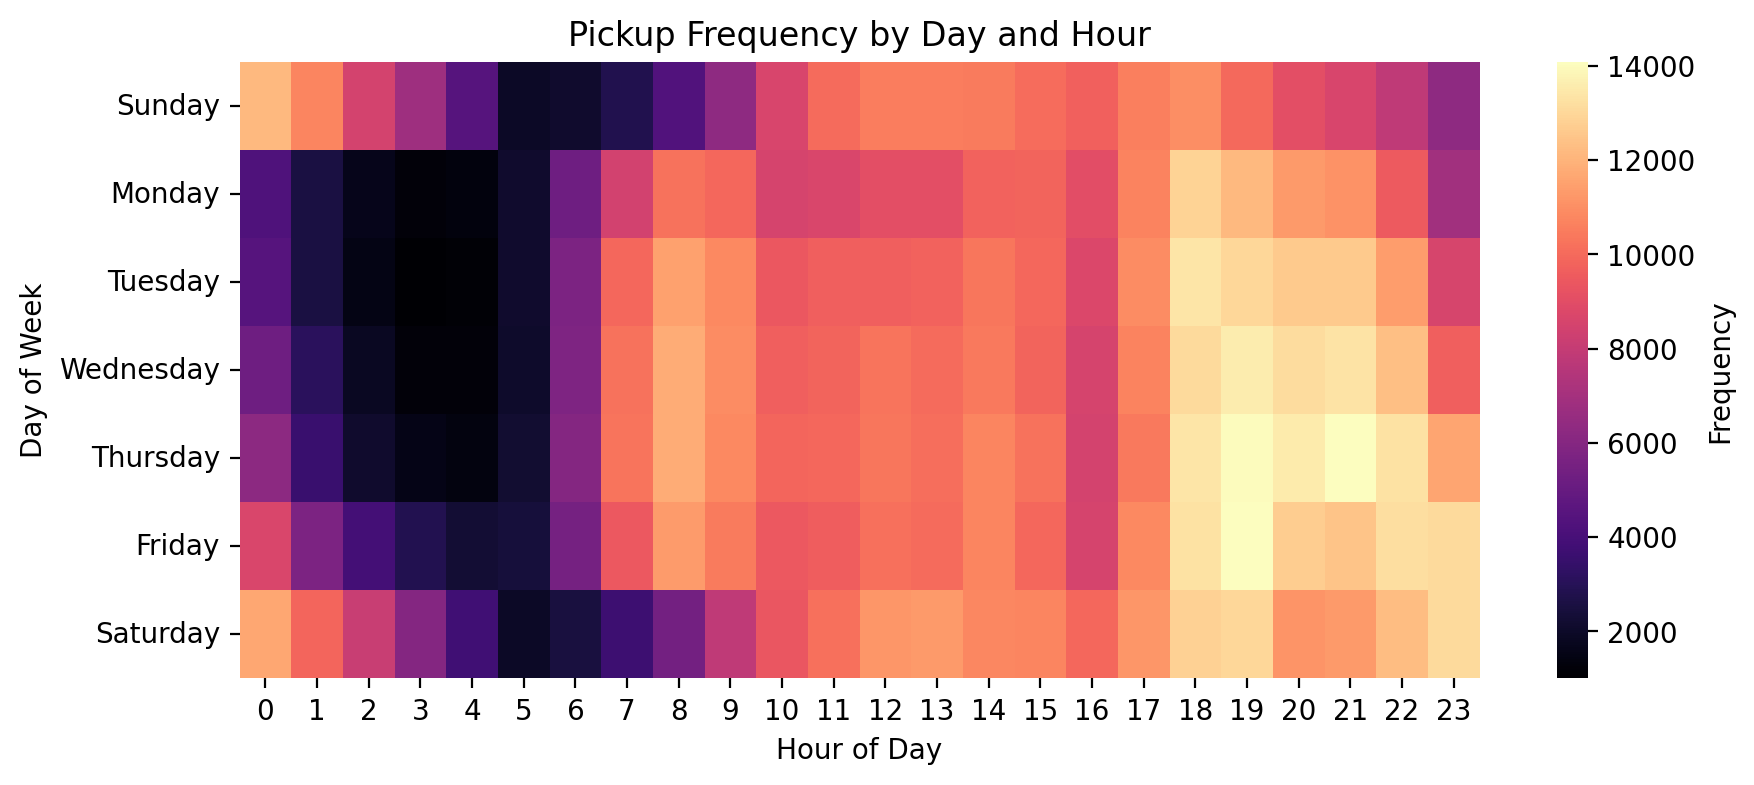

<Figure size 640x480 with 0 Axes>

In [32]:
# Create heatmap for frequency between days and hours.
# Get data
day_hour = X[['pickup_datetime', 'pickup_hour']]

# Create new column for day of the week
day_hour['day_of_week'] = day_hour['pickup_datetime'].dt.day_name()

# Define the order of days
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

pivot_table = day_hour.pivot_table(index='day_of_week', columns='pickup_hour', aggfunc='size', fill_value=0)
pivot_table.sort_index(ascending=False, inplace=True)
pivot_table = pivot_table.reindex(day_order)
pivot_table

# Create the heatmap using seaborn
plt.figure(figsize=(10, 4), dpi=200)
sns.heatmap(pivot_table, cmap='magma', fmt='d', cbar_kws={'label': 'Frequency'})
plt.title('Pickup Frequency by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.savefig('images/day_hour.png')
plt.show()

plt.savefig('images/day_hour.png')

# day_hour.head()


In [60]:
from sklearn import linear_model
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X1 = X.drop(columns=['vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

lasso_lars_ic = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC(criterion="bic", normalize=False)).fit(X_train, y_train)

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "BIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")

optimal_alpha = results[results['BIC criterion'] == results['BIC criterion'].min()].index

# Train a Lasso model with the optimal alpha for feature selection
lasso = linear_model.Lasso(alpha=optimal_alpha)
lasso.fit(X_train, y_train)

# {'Optimal Alpha': optimal_alpha.values[0], 'Optimal BIC': results.loc[optimal_alpha].values[0].tolist()[0],
#             'Lasso Coeffs': lasso.coef_.round(4), 'Important Features': X_train.columns[lasso.coef_ != 0].values}

y_pred = lasso.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared  Error: {mse:.4f}')



Mean Squared  Error: 368410.1542


In [70]:
def lasso_regression_model(optimal_alpha):
    # Important features selected from Lasso Lars IC Feature Selection
    important_features = ['pickup_minute', 'distance_km', 'temperature_2m (°C)', 'cloudcover (%)', 'avg_cluster_duration']

    # Create dataframe of important features
    X2 = X[important_features]

    # Get test train split
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

    # Create and fit the model.
    model = linear_model.Lasso(alpha=optimal_alpha)
    model.fit(X_train, y_train)

    # Predict on test data and compute RMSE
    y_pred = model.predict(X_test)
    return {'RMSE': mean_squared_error(y_test, y_pred, squared=False)}

lasso_regression_model(1.0806)

{'RMSE': 606.9680009195249}

In [68]:
# Compute lightgbm on optimized parameters and important features
# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

params = {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.5}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'Mean Squared Error: {mse:.4f}')

print("{'Best parameters from grid search': {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20,")
print("				      'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.5},")
print("'Best RMSE': 606.9699}")

{'Best parameters from grid search': {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20,
				      'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.5},
'Best RMSE': 606.9699}


In [6]:
X1 = X.drop(columns=['id', 'vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create param grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [30, 40],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'reg_alpha': [0.001, 0.01, 0.1, 0.5],
    'reg_lambda': [0.001, 0.01, 0.1, 0.5],
}

# LightGBM
lgb_train = lgb.LGBMRegressor()

# Grid search
grid_search = GridSearchCV(estimator=lgb_train, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best params
print('Best parameters from grid search: ', grid_search.best_params_)


KeyError: "['id'] not found in axis"

In [41]:
# Run light gbm on the best params with best features
X2 = X1[['pickup_month', 'pickup_hour', 'pickup_minute', 'distance_km', 'cloudcover (%)']]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
params = {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

lgb_best = lgb.LGBMRegressor(**params)
lgb_best.fit(X_train, y_train)
y_pred = lgb_best.predict(X_test)
print(f'R-squared X1: {r2_score(y_test, y_pred)}')
print(f'RMSLE X1: {mean_squared_log_error(y_test, y_pred, squared=False)}')

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
lgb_best = lgb.LGBMRegressor(**params)
lgb_best.fit(X_train, y_train)
y_pred = lgb_best.predict(X_test)
print(f'R-squared X2: {r2_score(y_test, y_pred)}')
print(f'RMSLE X2: {mean_squared_log_error(y_test, y_pred, squared=False)}')

R-squared X1: -2.66374427706495e-05
RMSLE X1: 0.7612960832486187
R-squared X2: -2.5227822131324018e-05
RMSLE X2: 0.7612910686040159


In [43]:
# Keep only pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, pickup_month, pickup_hour, pickup_period, distance
# X_c = X[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#             'pickup_month', 'pickup_hour', 'pickup_period', 'distance_km']]
# X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
# X = X.drop(columns=['id', 'pickup_datetime'])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7612956933912876


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [45]:
# Try log transformation of y
y_log = np.log(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y_log, test_size=0.2, random_state=42)

# Run xgboost regressor on the data.
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, n_jobs=1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict
y_pred = xgb_reg.predict(X_test)
print(mean_squared_log_error(np.exp(y_test), y_pred, squared=True))

20.416757344607447


In [49]:
print(mean_squared_log_error(np.exp(y_test), np.exp(y_pred), squared=False))

0.7208240949347663


In [51]:
pd.DataFrame({'Actual': np.exp(y_test), 'Predicted': np.exp(y_pred)})

,Actual,Predicted
1398060,289.000000,646.015686
274944,659.000000,651.532166
1043220,733.000000,645.393738
769154,731.000000,637.844238
1258561,1242.000000,647.302734
...,...,...
1188211,476.000000,646.208557
197210,583.000000,651.900391
1355987,352.000000,640.801025
106607,262.000000,634.399963


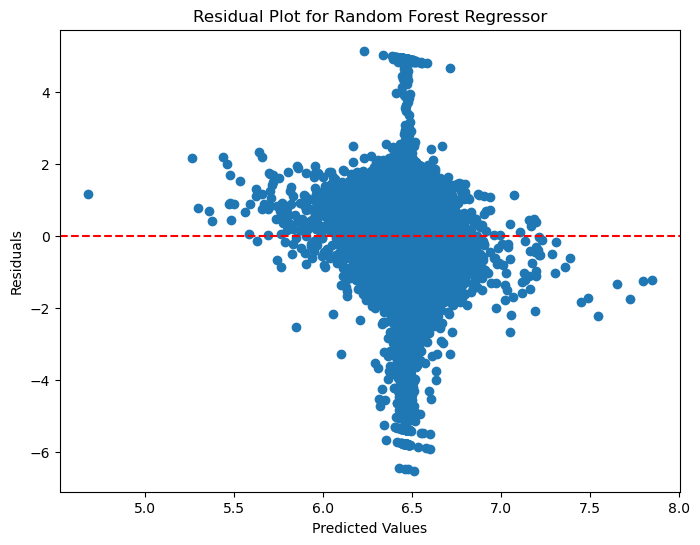

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(x=y_pred, y=residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor")
plt.show()

In [127]:
json_file_path = './misc/lat_long_bounds.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data from the file
    coords = json.load(json_file)
coords

{'lat': {'min': 40.49787800728235, 'max': 40.91510319260631},
 'lon': {'min': -74.25495645300373, 'max': -73.70002020503291},
 'code_str': '\nnyc_df = pd.read_csv(f"{data_path}/Centerline.csv")\nnyc_df = nyc_df.loc[:, [\'the_geom\']]\n\n# Convert the "the_geom" column to Shapely geometries\nnyc_df[\'the_geom_geopandas\'] = nyc_df[\'the_geom\'].apply(loads)\n\n# Create a GeoDataFrame\ngdf = gpd.GeoDataFrame(nyc_df, geometry=\'the_geom_geopandas\')\n\nmin_lon, min_lat, max_lon, max_lat = gdf[\'the_geom_geopandas\'].total_bounds\n'}

# Get rid of outlier variables

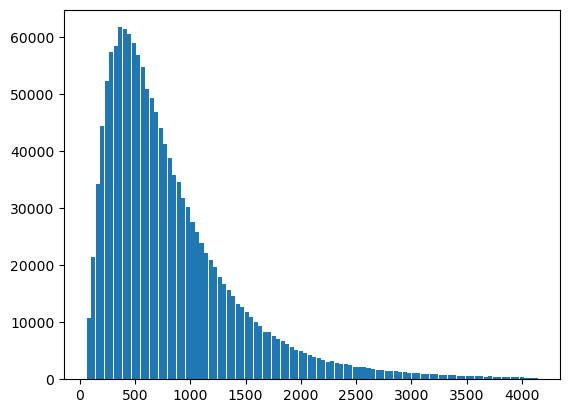

In [8]:
plt.hist(y, bins=100, rwidth=0.9)
plt.show()

(1442663, 24)
(1442663, 24)
(1435463, 24)
(1442663, 27)


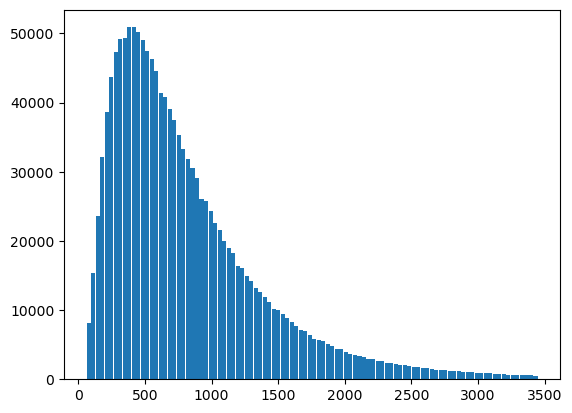

count   1435463.000000
mean        812.408177
std         574.502822
min          60.000000
25%         399.000000
50%         660.000000
75%        1061.000000
max        3448.000000
Name: trip_duration, dtype: float64

In [4]:
# Read in raw data
df = pd.read_csv(data_path + '/train_clean.csv')

# Drop trips less than 60 seconds
df = df[df['trip_duration'] >= 60]

# Get coordinates from json
json_file_path = './misc/lat_long_bounds.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data from the file
    coords = json.load(json_file)

# Get rid of lat long outliers
print(df.shape)
df = df[(df['pickup_latitude'] >= coords['lat']['min']) & (df['pickup_latitude'] <= coords['lat']['max'])]
df = df[(df['pickup_longitude'] >= coords['lon']['min']) & (df['pickup_longitude'] <= coords['lon']['max'])]

# Keep only <99.5% of trip duration
print(df.shape)
df1 = df[df['trip_duration'] <= df['trip_duration'].quantile(0.995)]
print(df1.shape)
print(X.shape)

# Plot histogram of trip duration
plt.hist(df1['trip_duration'], bins=100, rwidth=0.9)
plt.show()

df1.trip_duration.describe()


In [81]:
# Train test split
X_c = X.drop(columns=['pickup_datetime'])
X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

# Grid search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2],
    'lambda': [0.5, 0.4],
    'alpha': [0.5, 0.4],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}
xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)



# Evaluate based on Root Mean Squared Logarithmic Error.
y_pred = grid_search.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


0.525662602679601


<h3>Doing some basic data analysis</h3>

Task:
<ul>
<li>✅ Get most common pickup and dropoff locations.</li>
<li>Find the number of rows and columns</li>
<li>Find the data statistics</li>
</ul>

In [49]:
# Get the most common pickup longitude and latitude
pop_p_lat = X_c.pickup_latitude.value_counts().index[0]
pop_p_long = X_c[X_c.pickup_latitude == pop_p_lat].pickup_longitude.value_counts().index[0]

# Most common pickup location
com_pickup = (pop_p_lat, pop_p_long)  # This is actually the airport, so that makes sense.

# Get the most common dropoff latitude and longitude 
pop_d_lat = X_c.dropoff_latitude.value_counts().index[0]
pop_d_long = X_c[X_c.dropoff_latitude == pop_d_lat].dropoff_longitude.value_counts().index[0]

# Most common dropoff location
com_dropoff = (pop_d_lat, pop_d_long)  # This is actually the airport, so that makes sense.
com_dropoff

(40.774311, -73.872787)

Questions to consider in introduction:

While our primary investigation is focused on determining taxi cab trip duration, we are also interested in several other questions. What dates, days of the week, and times of day are most busy? Where are the most popular destinations? Furthermore, the multifaceted exploration of temporal, spatial, and environmental influences on travel durations in NYC presents a well-rounded analysis to reveal comprehensive insights into travel behaviors. This poses questions such as how do environmental factors such as rain impact taxi popularity? Which pickup and drop off locations have the highest average time by distance? Our data is well suited for our research question in exploring and predicting taxi trip duration, and has a single, clear answer. A process of machine learning model development will help us go one step further and develop a robust predictive model to estimate and understand trip durations accurately.

In [11]:
import seaborn as sns

In [10]:
# Creating actual vs. predicted plots for our four models.
# Data
X, y = get_X_y(force_clean=False)
# X, y = get_X_y()
X = generate_features(X, y)
X = X.drop(columns=['pickup_datetime'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [11]:
# Build each model with optimal parameters.
# Lasso
lasso = linear_model.Lasso(alpha=1.0806)
lasso.fit(X_train, y_train)

# See how well it did
y_pred_lasso = lasso.predict(X_test)

# XGBoost
xgb_reg = xgb.XGBRegressor(booster='gbtree', learning_rate=0.01, max_depth=10, n_estimators=100)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)



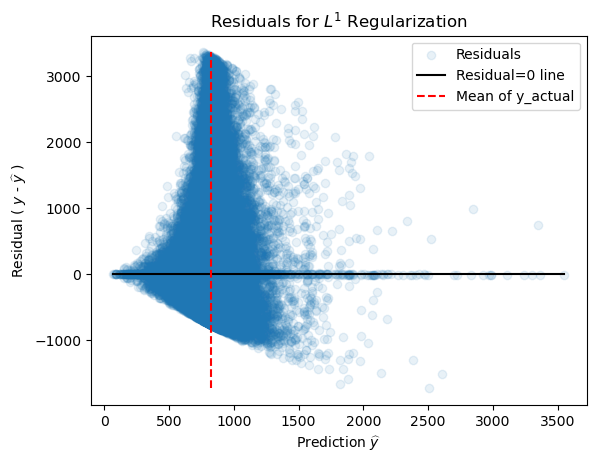

In [15]:
def plot_residual(y_actual, y_pred, title="Residuals for Random Forest"):
    """ plots a residual plot from the passed-in y_actual and y_pred
    """
    # compute the residuals
    residual = y_actual - y_pred
    
    # plot the residuals with the x-axis as the predictions and the y-axis
    # as the residuals (y_actual - y_pred)
    plt.scatter(y_pred, residual, alpha=0.1, label="Residuals")
    
    # plot the residual=0 line
    lower = np.min(y_pred)
    upper = np.max(y_pred)
    ls = np.linspace(lower, upper, 100)
    plt.plot(ls, np.zeros(len(ls)), color='black', label='Residual=0 line')
    
    # plot the mean of the actual data
    plt.vlines([np.mean(y_test)], ymin=np.min(residual), ymax=np.max(residual), linestyles='dashed', color='red', label='Mean of y_actual')
    
    # setup other plot parameters and show the plot
    plt.xlabel("Prediction $\widehat{y}$")
    plt.ylabel("Residual ( $y$ - $\widehat{y}$ )")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_residual(y_test, y_pred_lasso, title="Residuals for $L^1$ Regularization")

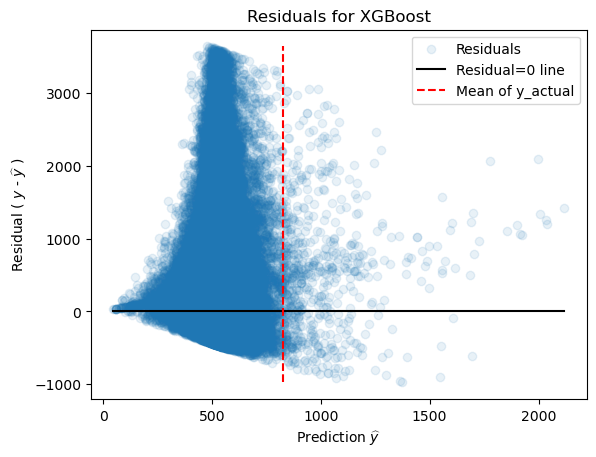

In [16]:
plot_residual(y_test, y_pred_xgb, title="Residuals for XGBoost")

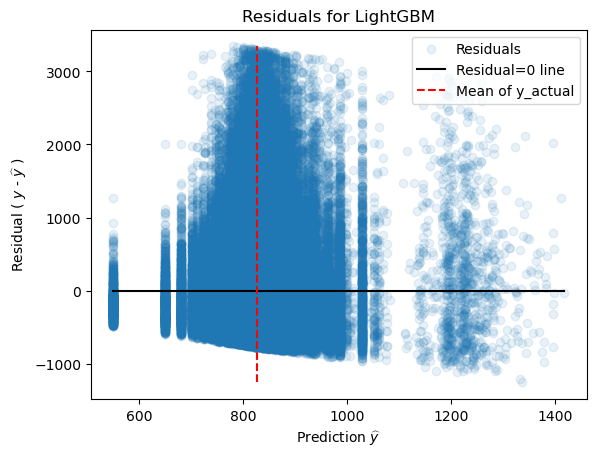

In [17]:
gbm_params = {
    "boosting_type": 'gbdt',
    "learning_rate": 0.01,
    "max_depth": 20,
    "n_estimators": 100,
    "num_leaves": 30,
    "reg_alpha": 0.1 ,
    "reg_lambda": 0.5,
}
import lightgbm as lgb
lgbm_train = lgb.LGBMRegressor(**gbm_params)
lgbm_train.fit(X_train, y_train, eval_metric='rmse')
y_pred_lqbm = lgbm_train.predict(X_test)

def plot_residual(y_actual, y_pred, title="Residuals for Random Forest"):
    """ plots a residual plot from the passed-in y_actual and y_pred
    """
    # compute the residuals
    residual = y_actual - y_pred
    
    # plot the residuals with the x-axis as the predictions and the y-axis
    # as the residuals (y_actual - y_pred)
    plt.scatter(y_pred, residual, alpha=0.1, label="Residuals")
    
    # plot the residual=0 line
    lower = np.min(y_pred)
    upper = np.max(y_pred)
    ls = np.linspace(lower, upper, 100)
    plt.plot(ls, np.zeros(len(ls)), color='black', label='Residual=0 line')
    
    # plot the mean of the actual data
    plt.vlines([np.mean(y_test)], ymin=np.min(residual), ymax=np.max(residual), linestyles='dashed', color='red', label='Mean of y_actual')
    
    # setup other plot parameters and show the plot
    plt.xlabel("Prediction $\widehat{y}$")
    plt.ylabel("Residual ( $y$ - $\widehat{y}$ )")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_residual(y_test, y_pred_lqbm, title="Residuals for LightGBM")